In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [2]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

In [3]:
train = load_dataset("../data/biasbios/hila/train.pickle")
dev = load_dataset("../data/biasbios/hila/dev.pickle")
test = load_dataset("../data/biasbios/hila/test.pickle")
counter = count_profs_and_gender(train+dev+test)
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")

path = "/home/nlp/lazary/workspace/thesis/nullspace_projection/data/bert_encode_biasbios_even_splits_hila/"
x_train = np.load(path + "train_cls.npy")
x_dev = np.load(path + "dev_cls.npy")
x_test = np.load(path + "test_cls.npy")

assert len(train) == len(x_train)
assert len(dev) == len(x_dev)
assert len(test) == len(x_test)

f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}


In [4]:
y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])

In [5]:
train[1]

{'g': 'm',
 'p': 'professor',
 'text': 'Tomas Norton is a tenure-track assistant professor in Precision Livestock Farming (PLF) in the group of M3-BIORES (Measure, Model, Manage Bio-responses) at the KU Leuven. He holds a PhD in Biosystems Engineering from University College Dublin (Ireland). He previously held academic positions at University College Dublin (Ireland), Dublin Institute of Technology (Ireland) and Harper Adams University (UK). He was a PhD research assistant at Teagasc Irish Agriculture and Food Development Authority. His current research focus is on PLF applications, focussing on real-time modelling and control of animal bio-responses. Tomas started as daily coordinator of the EU-PLF project (2012-2016) and now coordinates 4 Ph.D. students and Masters students in PLF at M3-BIORES. He is PI and co-PI on collaborative National and International projects. He also coordinator of courses on Measuring, Modelling and Managing Bio-responses and Sustainable PLF, and Animal Prod

In [77]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 10, max_iter = 5, n_jobs = 90, random_state = 1)

#params = {'}
#clf = SGDClassifier(loss= 'log', max_iter= 15, fit_intercept= True, class_weight= None, n_jobs= 100)
        
        
start = time.time()
idx = np.random.rand(x_train.shape[0]) < 1.0
clf.fit(x_train[idx], y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(x_test, y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 146 seconds
time: 146.7892563343048


[Parallel(n_jobs=90)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  2.4min finished


0.7988794435857806


In [78]:
print(clf.score(x_train, y_train))

0.8244925892612726


In [6]:
y_train[:100]

array([18, 20, 11, 21, 11, 24, 22, 21,  1,  1, 18, 25, 11,  2, 14, 13, 13,
       11, 21, 19, 10, 21, 21, 22, 21, 26,  0, 20,  3, 21, 19,  0, 26, 26,
       21, 21,  6, 18, 19, 21, 18, 21, 25, 22, 18, 21, 13, 21,  2, 21, 19,
       21, 21, 21,  2,  6, 18, 21, 21, 21, 21, 25,  0, 25, 21,  2, 18, 11,
       19, 13, 12, 14, 26, 18, 26, 21, 21,  9, 21, 26, 27,  1, 21, 24,  9,
       21, 19, 21, 12,  2, 21, 22, 21, 21, 14, 11, 21,  2, 21, 13])

In [113]:
MLP = False

def get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train_task, Y_dev_task, dim):

    is_autoregressive = True
    min_acc = 0.
    noise = False
    dim = 768
    n = num_clfs
    random_subset = 1.0
    start = time.time()
    TYPE= "svm"
    
    
    if MLP:
        x_train_gender = np.matmul(x_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(x_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = x_train.copy()
        x_dev_gender = x_dev.copy()
        
    
    if TYPE == "sgd":
        gender_clf = SGDClassifier
        params = {'loss': 'log', 'max_iter': 2000, 'fit_intercept': True, 'class_weight': None, 'n_jobs': 100}
    else:
        gender_clf = LinearSVC
        params = {'max_iter': 5000, 'fit_intercept': False, 'class_weight': None, "dual": False}
        
    P = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              X_train, Y_train_gender, X_dev, Y_dev_gender, noise=noise, random_subset = random_subset,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, all_data_prob = 0.0, by_class = True, k = 0,
                                       all_data_iterations = 0)
    print("time: {}".format(time.time() - start))
    return P



num_clfs = 400
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_train_gender = np.array([g2i[d["g"]] for d in train])
idx = np.random.rand(x_train.shape[0]) < 1.
P = get_projection_matrix(num_clfs, x_train[idx], y_train_gender[idx], x_dev, y_dev_gender, y_train, y_dev, 300)



  0%|          | 0/400 [00:00<?, ?it/s]

by class: True, all_data_iterations: 0, k: 0
Iteration 0, Accuracy: 0.9958596865554116




  0%|          | 1/400 [00:35<3:59:00, 35.94s/it]

Iteration 1, Accuracy: 0.9938687921520539




  0%|          | 2/400 [00:41<2:58:49, 26.96s/it]

Iteration 2, Accuracy: 0.9949874686716792




  1%|          | 3/400 [00:46<2:13:53, 20.24s/it]

Iteration 3, Accuracy: 0.9966295047964739




  1%|          | 4/400 [00:54<1:48:24, 16.43s/it]

Iteration 4, Accuracy: 0.9859154929577465




  1%|▏         | 5/400 [00:58<1:23:47, 12.73s/it]

Iteration 5, Accuracy: 0.9961685823754789




  2%|▏         | 6/400 [01:02<1:06:58, 10.20s/it]

Iteration 6, Accuracy: 0.9904966278356836




  2%|▏         | 7/400 [01:09<1:00:50,  9.29s/it]

Iteration 7, Accuracy: 0.9772079772079773




  2%|▏         | 8/400 [01:14<52:09,  7.98s/it]  

Iteration 8, Accuracy: 0.9901185770750988




  2%|▏         | 9/400 [01:19<45:39,  7.01s/it]

Iteration 9, Accuracy: 0.9803571428571428




  2%|▎         | 10/400 [01:23<41:01,  6.31s/it]

Iteration 10, Accuracy: 0.9482142857142857




  3%|▎         | 11/400 [01:29<38:41,  5.97s/it]

Iteration 11, Accuracy: 0.9566929133858267




  3%|▎         | 12/400 [01:33<36:11,  5.60s/it]

Iteration 12, Accuracy: 0.9783236994219653




  3%|▎         | 13/400 [01:38<33:52,  5.25s/it]

Iteration 13, Accuracy: 0.9252669039145908




  4%|▎         | 14/400 [01:42<32:23,  5.04s/it]

Iteration 14, Accuracy: 0.9320905459387483




  4%|▍         | 15/400 [01:47<32:04,  5.00s/it]

Iteration 15, Accuracy: 0.9508670520231214




  4%|▍         | 16/400 [01:53<32:38,  5.10s/it]

Iteration 16, Accuracy: 0.8740157480314961




  4%|▍         | 17/400 [01:57<30:22,  4.76s/it]

Iteration 17, Accuracy: 0.9421081376297106




  4%|▍         | 18/400 [02:02<31:17,  4.91s/it]

Iteration 18, Accuracy: 0.9339285714285714




  5%|▍         | 19/400 [02:07<31:36,  4.98s/it]

Iteration 19, Accuracy: 0.9766339315949881




  5%|▌         | 20/400 [02:37<1:19:33, 12.56s/it]

Iteration 20, Accuracy: 0.8543307086614174




  5%|▌         | 21/400 [02:41<1:03:07,  9.99s/it]

Iteration 21, Accuracy: 0.9457364341085271




  6%|▌         | 22/400 [02:45<51:58,  8.25s/it]  

Iteration 22, Accuracy: 0.9097222222222222




  6%|▌         | 23/400 [02:49<43:06,  6.86s/it]

Iteration 23, Accuracy: 0.946360153256705




  6%|▌         | 24/400 [02:52<36:24,  5.81s/it]

Iteration 24, Accuracy: 0.8993288590604027




  6%|▋         | 25/400 [02:56<32:09,  5.15s/it]

Iteration 25, Accuracy: 0.9335260115606936




  6%|▋         | 26/400 [03:00<30:19,  4.87s/it]

Iteration 26, Accuracy: 0.9186046511627907




  7%|▋         | 27/400 [03:05<30:02,  4.83s/it]

Iteration 27, Accuracy: 0.9071428571428571




  7%|▋         | 28/400 [03:09<28:43,  4.63s/it]

Iteration 28, Accuracy: 0.8974358974358975




  7%|▋         | 29/400 [03:14<29:01,  4.69s/it]

Iteration 29, Accuracy: 0.8790123456790123




  8%|▊         | 30/400 [03:21<33:43,  5.47s/it]

Iteration 30, Accuracy: 0.8456375838926175




  8%|▊         | 31/400 [03:25<30:22,  4.94s/it]

Iteration 31, Accuracy: 0.9573234984193888




  8%|▊         | 32/400 [03:30<30:35,  4.99s/it]

Iteration 32, Accuracy: 0.906608410704533




  8%|▊         | 33/400 [03:38<36:18,  5.93s/it]

Iteration 33, Accuracy: 0.945479641131815




  8%|▊         | 34/400 [03:43<34:09,  5.60s/it]

Iteration 34, Accuracy: 0.8851351351351351




  9%|▉         | 35/400 [03:47<30:49,  5.07s/it]

Iteration 35, Accuracy: 0.9041278295605859




  9%|▉         | 36/400 [03:51<29:28,  4.86s/it]

Iteration 36, Accuracy: 0.884504726674887




  9%|▉         | 37/400 [04:00<36:27,  6.03s/it]

Iteration 37, Accuracy: 0.9284417941405237




 10%|▉         | 38/400 [04:09<42:33,  7.05s/it]

Iteration 38, Accuracy: 0.9549356223175965




 10%|▉         | 39/400 [04:18<44:55,  7.47s/it]

Iteration 39, Accuracy: 0.7986111111111112




 10%|█         | 40/400 [04:22<38:20,  6.39s/it]

Iteration 40, Accuracy: 0.9101123595505618




 10%|█         | 41/400 [04:25<33:02,  5.52s/it]

Iteration 41, Accuracy: 0.7722419928825622




 10%|█         | 42/400 [04:29<30:45,  5.16s/it]

Iteration 42, Accuracy: 0.881491344873502




 11%|█         | 43/400 [04:34<29:02,  4.88s/it]

Iteration 43, Accuracy: 0.9475956654249915




 11%|█         | 44/400 [04:57<1:01:25, 10.35s/it]

Iteration 44, Accuracy: 0.8702404809619239




 11%|█▏        | 45/400 [05:05<56:33,  9.56s/it]  

Iteration 45, Accuracy: 0.8681757656458056




 12%|█▏        | 46/400 [05:09<47:44,  8.09s/it]

Iteration 46, Accuracy: 0.9107142857142857




 12%|█▏        | 47/400 [05:13<40:17,  6.85s/it]

Iteration 47, Accuracy: 0.825925925925926




 12%|█▏        | 48/400 [05:20<40:45,  6.95s/it]

Iteration 48, Accuracy: 0.8236472945891784




 12%|█▏        | 49/400 [05:29<43:08,  7.38s/it]

Iteration 49, Accuracy: 0.7361111111111112




 12%|█▎        | 50/400 [05:32<35:43,  6.12s/it]

Iteration 50, Accuracy: 0.8735632183908046




 13%|█▎        | 51/400 [05:36<31:48,  5.47s/it]

Iteration 51, Accuracy: 0.8110236220472441




 13%|█▎        | 52/400 [05:40<28:47,  4.96s/it]

Iteration 52, Accuracy: 0.9523809523809523




 13%|█▎        | 53/400 [05:44<26:58,  4.66s/it]

Iteration 53, Accuracy: 0.8521970705725699




 14%|█▎        | 54/400 [05:48<27:09,  4.71s/it]

Iteration 54, Accuracy: 0.8708010335917312




 14%|█▍        | 55/400 [05:53<27:06,  4.71s/it]

Iteration 55, Accuracy: 0.8547008547008547




 14%|█▍        | 56/400 [05:58<26:44,  4.66s/it]

Iteration 56, Accuracy: 0.8809523809523809




 14%|█▍        | 57/400 [06:01<24:30,  4.29s/it]

Iteration 57, Accuracy: 0.7569444444444444




 14%|█▍        | 58/400 [06:05<24:15,  4.26s/it]

Iteration 58, Accuracy: 0.8162762022194822




 15%|█▍        | 59/400 [06:15<34:07,  6.00s/it]

Iteration 59, Accuracy: 0.9074187614960147




 15%|█▌        | 60/400 [06:25<39:30,  6.97s/it]

Iteration 60, Accuracy: 0.9017341040462428




 15%|█▌        | 61/400 [06:30<37:04,  6.56s/it]

Iteration 61, Accuracy: 0.8685770750988142




 16%|█▌        | 62/400 [06:36<35:46,  6.35s/it]

Iteration 62, Accuracy: 0.8873239436619719




 16%|█▌        | 63/400 [06:40<31:09,  5.55s/it]

Iteration 63, Accuracy: 0.9223057644110275




 16%|█▌        | 64/400 [06:44<29:41,  5.30s/it]

Iteration 64, Accuracy: 0.952054794520548




 16%|█▋        | 65/400 [06:51<31:21,  5.62s/it]

Iteration 65, Accuracy: 0.8160919540229885




 16%|█▋        | 66/400 [06:55<29:28,  5.29s/it]

Iteration 66, Accuracy: 0.8591549295774648




 17%|█▋        | 67/400 [07:00<27:40,  4.99s/it]

Iteration 67, Accuracy: 0.8595953402820355




 17%|█▋        | 68/400 [07:11<38:11,  6.90s/it]

Iteration 68, Accuracy: 0.8892857142857142




 17%|█▋        | 69/400 [07:16<34:54,  6.33s/it]

Iteration 69, Accuracy: 0.9397590361445783




 18%|█▊        | 70/400 [07:22<33:41,  6.13s/it]

Iteration 70, Accuracy: 0.8447293447293447




 18%|█▊        | 71/400 [07:27<32:20,  5.90s/it]

Iteration 71, Accuracy: 0.8348868175765646




 18%|█▊        | 72/400 [07:32<30:58,  5.67s/it]

Iteration 72, Accuracy: 0.7952755905511811




 18%|█▊        | 73/400 [07:37<28:50,  5.29s/it]

Iteration 73, Accuracy: 0.8212752912323728




 18%|█▊        | 74/400 [07:48<38:47,  7.14s/it]

Iteration 74, Accuracy: 0.8481703986892408




 19%|█▉        | 75/400 [07:56<40:48,  7.53s/it]

Iteration 75, Accuracy: 0.8450704225352113




 19%|█▉        | 76/400 [08:00<34:35,  6.41s/it]

Iteration 76, Accuracy: 0.9292168674698795




 19%|█▉        | 77/400 [08:06<34:04,  6.33s/it]

Iteration 77, Accuracy: 0.8590604026845637




 20%|█▉        | 78/400 [08:10<30:09,  5.62s/it]

Iteration 78, Accuracy: 0.7471264367816092




 20%|█▉        | 79/400 [08:14<27:39,  5.17s/it]

Iteration 79, Accuracy: 0.8319937775473165




 20%|██        | 80/400 [08:29<42:15,  7.92s/it]

Iteration 80, Accuracy: 0.9420442571127503




 20%|██        | 81/400 [08:37<42:12,  7.94s/it]

Iteration 81, Accuracy: 0.8243243243243243




 20%|██        | 82/400 [08:41<35:22,  6.68s/it]

Iteration 82, Accuracy: 0.7760521042084169




 21%|██        | 83/400 [08:50<39:25,  7.46s/it]

Iteration 83, Accuracy: 0.8309859154929577




 21%|██        | 84/400 [08:54<33:47,  6.42s/it]

Iteration 84, Accuracy: 0.8661971830985915




 21%|██▏       | 85/400 [08:58<29:42,  5.66s/it]

Iteration 85, Accuracy: 0.880057803468208




 22%|██▏       | 86/400 [09:03<28:24,  5.43s/it]

Iteration 86, Accuracy: 0.7493827160493827




 22%|██▏       | 87/400 [09:11<32:15,  6.18s/it]

Iteration 87, Accuracy: 0.865606936416185




 22%|██▏       | 88/400 [09:16<30:20,  5.84s/it]

Iteration 88, Accuracy: 0.8861283643892339




 22%|██▏       | 89/400 [09:23<32:18,  6.23s/it]

Iteration 89, Accuracy: 0.9172932330827067




 22%|██▎       | 90/400 [09:27<29:21,  5.68s/it]

Iteration 90, Accuracy: 0.8818151032847952




 23%|██▎       | 91/400 [09:55<1:03:30, 12.33s/it]

Iteration 91, Accuracy: 0.9066265060240963




 23%|██▎       | 92/400 [10:02<54:48, 10.68s/it]  

Iteration 92, Accuracy: 0.7919463087248322




 23%|██▎       | 93/400 [10:06<45:10,  8.83s/it]

Iteration 93, Accuracy: 0.8467908902691511




 24%|██▎       | 94/400 [10:15<44:49,  8.79s/it]

Iteration 94, Accuracy: 0.7662835249042146




 24%|██▍       | 95/400 [10:19<37:52,  7.45s/it]

Iteration 95, Accuracy: 0.848202396804261




 24%|██▍       | 96/400 [10:25<34:41,  6.85s/it]

Iteration 96, Accuracy: 0.8820224719101124




 24%|██▍       | 97/400 [10:29<30:36,  6.06s/it]

Iteration 97, Accuracy: 0.8589285714285714




 24%|██▍       | 98/400 [10:34<29:08,  5.79s/it]

Iteration 98, Accuracy: 0.823943661971831




 25%|██▍       | 99/400 [10:38<26:19,  5.25s/it]

Iteration 99, Accuracy: 0.8392857142857143




 25%|██▌       | 100/400 [10:43<25:44,  5.15s/it]

Iteration 100, Accuracy: 0.8825301204819277




 25%|██▌       | 101/400 [10:50<28:29,  5.72s/it]

Iteration 101, Accuracy: 0.831357941076871




 26%|██▌       | 102/400 [11:24<1:10:36, 14.22s/it]

Iteration 102, Accuracy: 0.7568058076225045




 26%|██▌       | 103/400 [11:37<1:08:20, 13.81s/it]

Iteration 103, Accuracy: 0.6527777777777778




 26%|██▌       | 104/400 [11:41<54:08, 10.97s/it]  

Iteration 104, Accuracy: 0.875




 26%|██▋       | 105/400 [11:45<43:08,  8.78s/it]

Iteration 105, Accuracy: 0.7321752657505833




 26%|██▋       | 106/400 [11:58<48:31,  9.90s/it]

Iteration 106, Accuracy: 0.7637795275590551




 27%|██▋       | 107/400 [12:01<39:11,  8.03s/it]

Iteration 107, Accuracy: 0.9107142857142857




 27%|██▋       | 108/400 [12:05<32:14,  6.63s/it]

Iteration 108, Accuracy: 0.821256038647343




 27%|██▋       | 109/400 [12:12<33:15,  6.86s/it]

Iteration 109, Accuracy: 0.7583230579531443




 28%|██▊       | 110/400 [12:22<37:51,  7.83s/it]

Iteration 110, Accuracy: 0.9362486828240253




 28%|██▊       | 111/400 [12:29<35:53,  7.45s/it]

Iteration 111, Accuracy: 0.7098232634607481




 28%|██▊       | 112/400 [12:43<46:02,  9.59s/it]

Iteration 112, Accuracy: 0.9298245614035088




 28%|██▊       | 113/400 [12:48<38:22,  8.02s/it]

Iteration 113, Accuracy: 0.8426966292134831




 28%|██▊       | 114/400 [12:51<32:24,  6.80s/it]

Iteration 114, Accuracy: 0.8338150289017341




 29%|██▉       | 115/400 [12:57<29:54,  6.30s/it]

Iteration 115, Accuracy: 0.8120805369127517




 29%|██▉       | 116/400 [13:01<27:01,  5.71s/it]

Iteration 116, Accuracy: 0.773758430410791




 29%|██▉       | 117/400 [13:14<37:00,  7.85s/it]

Iteration 117, Accuracy: 0.8108108108108109




 30%|██▉       | 118/400 [13:18<31:29,  6.70s/it]

Iteration 118, Accuracy: 0.9304531085353003




 30%|██▉       | 119/400 [13:26<33:02,  7.06s/it]

Iteration 119, Accuracy: 0.810077519379845




 30%|███       | 120/400 [13:31<30:06,  6.45s/it]

Iteration 120, Accuracy: 0.7998619737750172




 30%|███       | 121/400 [13:38<31:37,  6.80s/it]

Iteration 121, Accuracy: 0.7590435315757205




 30%|███       | 122/400 [13:49<37:08,  8.02s/it]

Iteration 122, Accuracy: 0.8241106719367589




 31%|███       | 123/400 [13:55<33:49,  7.33s/it]

Iteration 123, Accuracy: 0.8513513513513513




 31%|███       | 124/400 [13:58<28:29,  6.19s/it]

Iteration 124, Accuracy: 0.7553249590387766




 31%|███▏      | 125/400 [14:08<33:14,  7.25s/it]

Iteration 125, Accuracy: 0.8539325842696629




 32%|███▏      | 126/400 [14:12<28:43,  6.29s/it]

Iteration 126, Accuracy: 0.8314606741573034




 32%|███▏      | 127/400 [14:16<25:02,  5.50s/it]

Iteration 127, Accuracy: 0.8132411067193676




 32%|███▏      | 128/400 [14:22<25:26,  5.61s/it]

Iteration 128, Accuracy: 0.7192790824685964




 32%|███▏      | 129/400 [14:31<30:52,  6.84s/it]

Iteration 129, Accuracy: 0.8309859154929577




 32%|███▎      | 130/400 [14:35<26:41,  5.93s/it]

Iteration 130, Accuracy: 0.7222562844880441




 33%|███▎      | 131/400 [14:47<34:54,  7.79s/it]

Iteration 131, Accuracy: 0.7638339920948617




 33%|███▎      | 132/400 [14:54<32:49,  7.35s/it]

Iteration 132, Accuracy: 0.7737893667456823




 33%|███▎      | 133/400 [15:27<1:06:49, 15.02s/it]

Iteration 133, Accuracy: 0.8309859154929577




 34%|███▎      | 134/400 [15:30<51:18, 11.57s/it]  

Iteration 134, Accuracy: 0.7855297157622739




 34%|███▍      | 135/400 [15:36<42:53,  9.71s/it]

Iteration 135, Accuracy: 0.7188612099644128




 34%|███▍      | 136/400 [15:40<35:23,  8.04s/it]

Iteration 136, Accuracy: 0.7377243481205553




 34%|███▍      | 137/400 [16:21<1:19:22, 18.11s/it]

Iteration 137, Accuracy: 0.7991329479768786




 34%|███▍      | 138/400 [16:27<1:02:51, 14.40s/it]

Iteration 138, Accuracy: 0.6818742293464858




 35%|███▍      | 139/400 [16:37<56:28, 12.98s/it]  

Iteration 139, Accuracy: 0.7081545064377682




 35%|███▌      | 140/400 [16:50<56:35, 13.06s/it]

Iteration 140, Accuracy: 0.8309859154929577




 35%|███▌      | 141/400 [16:53<43:59, 10.19s/it]

Iteration 141, Accuracy: 0.7586206896551724




 36%|███▌      | 142/400 [16:58<36:28,  8.48s/it]

Iteration 142, Accuracy: 0.7318007662835249




 36%|███▌      | 143/400 [17:02<30:15,  7.06s/it]

Iteration 143, Accuracy: 0.9120126448893572




 36%|███▌      | 144/400 [17:10<31:40,  7.42s/it]

Iteration 144, Accuracy: 0.8521970705725699




 36%|███▋      | 145/400 [17:15<28:05,  6.61s/it]

Iteration 145, Accuracy: 0.7929606625258799




 36%|███▋      | 146/400 [17:24<31:30,  7.44s/it]

Iteration 146, Accuracy: 0.9067439409905164




 37%|███▋      | 147/400 [17:31<31:20,  7.43s/it]

Iteration 147, Accuracy: 0.8120805369127517




 37%|███▋      | 148/400 [17:35<26:44,  6.37s/it]

Iteration 148, Accuracy: 0.7194388777555111




 37%|███▋      | 149/400 [17:44<29:20,  7.02s/it]

Iteration 149, Accuracy: 0.6824034334763949




 38%|███▊      | 150/400 [17:55<34:24,  8.26s/it]

Iteration 150, Accuracy: 0.7080246913580247




 38%|███▊      | 151/400 [18:02<32:37,  7.86s/it]

Iteration 151, Accuracy: 0.8162393162393162




 38%|███▊      | 152/400 [18:07<28:49,  6.97s/it]

Iteration 152, Accuracy: 0.6876543209876543




 38%|███▊      | 153/400 [18:16<31:16,  7.60s/it]

Iteration 153, Accuracy: 0.8309859154929577




 38%|███▊      | 154/400 [18:20<26:38,  6.50s/it]

Iteration 154, Accuracy: 0.9348370927318296




 39%|███▉      | 155/400 [18:24<23:21,  5.72s/it]

Iteration 155, Accuracy: 0.6876543209876543




 39%|███▉      | 156/400 [18:41<36:49,  9.06s/it]

Iteration 156, Accuracy: 0.8232142857142857




 39%|███▉      | 157/400 [18:45<31:24,  7.76s/it]

Iteration 157, Accuracy: 0.8035714285714286




 40%|███▉      | 158/400 [18:50<27:45,  6.88s/it]

Iteration 158, Accuracy: 0.8




 40%|███▉      | 159/400 [18:55<25:32,  6.36s/it]

Iteration 159, Accuracy: 0.7394636015325671




 40%|████      | 160/400 [19:00<23:28,  5.87s/it]

Iteration 160, Accuracy: 0.6650226058364159




 40%|████      | 161/400 [19:10<27:54,  7.01s/it]

Iteration 161, Accuracy: 0.7543133195307108




 40%|████      | 162/400 [19:18<29:15,  7.38s/it]

Iteration 162, Accuracy: 0.9072708113804004




 41%|████      | 163/400 [19:28<31:52,  8.07s/it]

Iteration 163, Accuracy: 0.8378378378378378




 41%|████      | 164/400 [19:31<26:29,  6.74s/it]

Iteration 164, Accuracy: 0.7545219638242894




 41%|████▏     | 165/400 [19:38<26:07,  6.67s/it]

Iteration 165, Accuracy: 0.6623456790123456




 42%|████▏     | 166/400 [19:48<29:50,  7.65s/it]

Iteration 166, Accuracy: 0.741106719367589




 42%|████▏     | 167/400 [19:54<28:30,  7.34s/it]

Iteration 167, Accuracy: 0.6693386773547094




 42%|████▏     | 168/400 [20:07<34:04,  8.81s/it]

Iteration 168, Accuracy: 0.7061714909885308




 42%|████▏     | 169/400 [20:19<38:03,  9.88s/it]

Iteration 169, Accuracy: 0.8495339547270306




 42%|████▎     | 170/400 [20:24<32:24,  8.45s/it]

Iteration 170, Accuracy: 0.8202247191011236




 43%|████▎     | 171/400 [20:28<27:20,  7.16s/it]

Iteration 171, Accuracy: 0.6517473942366646




 43%|████▎     | 172/400 [20:46<39:11, 10.31s/it]

Iteration 172, Accuracy: 0.643238799835594




 43%|████▎     | 173/400 [20:58<41:16, 10.91s/it]

Iteration 173, Accuracy: 0.8772590361445783




 44%|████▎     | 174/400 [21:07<38:32, 10.23s/it]

Iteration 174, Accuracy: 0.9323308270676691




 44%|████▍     | 175/400 [21:11<32:02,  8.55s/it]

Iteration 175, Accuracy: 0.6645060928182526




 44%|████▍     | 176/400 [21:37<50:44, 13.59s/it]

Iteration 176, Accuracy: 0.7437722419928826




 44%|████▍     | 177/400 [21:41<40:04, 10.78s/it]

Iteration 177, Accuracy: 0.7913385826771654




 44%|████▍     | 178/400 [21:45<32:37,  8.82s/it]

Iteration 178, Accuracy: 0.8581081081081081




 45%|████▍     | 179/400 [21:49<27:09,  7.37s/it]

Iteration 179, Accuracy: 0.8772590361445783




 45%|████▌     | 180/400 [21:58<28:32,  7.78s/it]

Iteration 180, Accuracy: 0.7203065134099617




 45%|████▌     | 181/400 [22:03<25:10,  6.90s/it]

Iteration 181, Accuracy: 0.7432712215320911




 46%|████▌     | 182/400 [22:11<26:51,  7.39s/it]

Iteration 182, Accuracy: 0.8426966292134831




 46%|████▌     | 183/400 [22:16<23:16,  6.43s/it]

Iteration 183, Accuracy: 0.7832369942196532




 46%|████▌     | 184/400 [22:21<21:38,  6.01s/it]

Iteration 184, Accuracy: 0.7716535433070866




 46%|████▋     | 185/400 [22:25<19:38,  5.48s/it]

Iteration 185, Accuracy: 0.7292490118577075




 46%|████▋     | 186/400 [22:31<20:02,  5.62s/it]

Iteration 186, Accuracy: 0.8017857142857143




 47%|████▋     | 187/400 [22:36<19:03,  5.37s/it]

Iteration 187, Accuracy: 0.8409893992932862




 47%|████▋     | 188/400 [22:41<18:31,  5.24s/it]

Iteration 188, Accuracy: 0.6518518518518519




 47%|████▋     | 189/400 [22:47<20:06,  5.72s/it]

Iteration 189, Accuracy: 0.875




 48%|████▊     | 190/400 [22:51<18:17,  5.22s/it]

Iteration 190, Accuracy: 0.8309859154929577




 48%|████▊     | 191/400 [22:55<16:53,  4.85s/it]

Iteration 191, Accuracy: 0.7982142857142858




 48%|████▊     | 192/400 [23:00<16:53,  4.87s/it]

Iteration 192, Accuracy: 0.693950177935943




 48%|████▊     | 193/400 [23:05<16:15,  4.71s/it]

Iteration 193, Accuracy: 0.7471264367816092




 48%|████▊     | 194/400 [23:09<15:34,  4.54s/it]

Iteration 194, Accuracy: 0.7774566473988439




 49%|████▉     | 195/400 [23:14<15:51,  4.64s/it]

Iteration 195, Accuracy: 0.6288532675709001




 49%|████▉     | 196/400 [23:25<22:07,  6.51s/it]

Iteration 196, Accuracy: 0.7972972972972973




 49%|████▉     | 197/400 [23:28<19:24,  5.74s/it]

Iteration 197, Accuracy: 0.8309859154929577




 50%|████▉     | 198/400 [23:32<17:32,  5.21s/it]

Iteration 198, Accuracy: 0.7745664739884393




 50%|████▉     | 199/400 [23:38<17:29,  5.22s/it]

Iteration 199, Accuracy: 0.8370786516853933




 50%|█████     | 200/400 [23:42<16:07,  4.84s/it]

Iteration 200, Accuracy: 0.708185053380783




 50%|█████     | 201/400 [23:46<15:27,  4.66s/it]

Iteration 201, Accuracy: 0.7535612535612536




 50%|█████     | 202/400 [23:51<15:54,  4.82s/it]

Iteration 202, Accuracy: 0.6877751439214358




 51%|█████     | 203/400 [24:23<42:51, 13.06s/it]

Iteration 203, Accuracy: 0.8787650602409639




 51%|█████     | 204/400 [24:30<36:04, 11.04s/it]

Iteration 204, Accuracy: 0.7897526501766784




 51%|█████▏    | 205/400 [24:35<29:51,  9.19s/it]

Iteration 205, Accuracy: 0.6636471385032171




 52%|█████▏    | 206/400 [27:45<3:25:41, 63.62s/it]

Iteration 206, Accuracy: 0.9323308270676691




 52%|█████▏    | 207/400 [27:49<2:27:16, 45.78s/it]

Iteration 207, Accuracy: 0.65




 52%|█████▏    | 208/400 [27:56<1:49:09, 34.11s/it]

Iteration 208, Accuracy: 0.7164031620553359




 52%|█████▏    | 209/400 [28:01<1:20:53, 25.41s/it]

Iteration 209, Accuracy: 0.7526501766784452




 52%|█████▎    | 210/400 [28:06<1:00:32, 19.12s/it]

Iteration 210, Accuracy: 0.8309859154929577




 53%|█████▎    | 211/400 [28:09<45:34, 14.47s/it]  

Iteration 211, Accuracy: 0.7041343669250646




 53%|█████▎    | 212/400 [28:15<36:35, 11.68s/it]

Iteration 212, Accuracy: 0.7982142857142858




 53%|█████▎    | 213/400 [28:19<29:52,  9.58s/it]

Iteration 213, Accuracy: 0.8772590361445783




 54%|█████▎    | 214/400 [28:26<27:04,  8.73s/it]

Iteration 214, Accuracy: 0.6492985971943888




 54%|█████▍    | 215/400 [28:33<25:32,  8.28s/it]

Iteration 215, Accuracy: 0.8772590361445783




 54%|█████▍    | 216/400 [28:39<23:31,  7.67s/it]

Iteration 216, Accuracy: 0.8765060240963856




 54%|█████▍    | 217/400 [28:45<21:34,  7.07s/it]

Iteration 217, Accuracy: 0.7745664739884393




 55%|█████▍    | 218/400 [28:50<19:19,  6.37s/it]

Iteration 218, Accuracy: 0.6834625322997416




 55%|█████▍    | 219/400 [28:55<18:23,  6.10s/it]

Iteration 219, Accuracy: 0.8370786516853933




 55%|█████▌    | 220/400 [28:59<16:17,  5.43s/it]

Iteration 220, Accuracy: 0.6908793009284544




 55%|█████▌    | 221/400 [29:07<17:51,  5.98s/it]

Iteration 221, Accuracy: 0.8402130492676432




 56%|█████▌    | 222/400 [29:11<16:16,  5.49s/it]

Iteration 222, Accuracy: 0.8258426966292135




 56%|█████▌    | 223/400 [29:15<14:52,  5.04s/it]

Iteration 223, Accuracy: 0.8428761651131824




 56%|█████▌    | 224/400 [29:19<14:05,  4.80s/it]

Iteration 224, Accuracy: 0.8




 56%|█████▋    | 225/400 [29:23<13:30,  4.63s/it]

Iteration 225, Accuracy: 0.698005698005698




 56%|█████▋    | 226/400 [29:28<13:25,  4.63s/it]

Iteration 226, Accuracy: 0.7407407407407407




 57%|█████▋    | 227/400 [29:33<13:18,  4.62s/it]

Iteration 227, Accuracy: 0.6434108527131783




 57%|█████▋    | 228/400 [29:40<15:50,  5.53s/it]

Iteration 228, Accuracy: 0.6364197530864197




 57%|█████▋    | 229/400 [29:47<17:16,  6.06s/it]

Iteration 229, Accuracy: 0.8765060240963856




 57%|█████▊    | 230/400 [29:56<19:16,  6.80s/it]

Iteration 230, Accuracy: 0.7279693486590039




 58%|█████▊    | 231/400 [30:01<17:21,  6.16s/it]

Iteration 231, Accuracy: 0.6419753086419753




 58%|█████▊    | 232/400 [30:14<22:52,  8.17s/it]

Iteration 232, Accuracy: 0.6207414829659319




 58%|█████▊    | 233/400 [30:23<23:53,  8.58s/it]

Iteration 233, Accuracy: 0.6421188630490956




 58%|█████▊    | 234/400 [30:29<21:15,  7.68s/it]

Iteration 234, Accuracy: 0.6207414829659319




 59%|█████▉    | 235/400 [30:43<26:23,  9.59s/it]

Iteration 235, Accuracy: 0.6083025071927661




 59%|█████▉    | 236/400 [30:52<25:53,  9.47s/it]

Iteration 236, Accuracy: 0.9323308270676691




 59%|█████▉    | 237/400 [30:57<22:03,  8.12s/it]

Iteration 237, Accuracy: 0.6450617283950617




 60%|█████▉    | 238/400 [31:04<21:20,  7.90s/it]

Iteration 238, Accuracy: 0.8314606741573034




 60%|█████▉    | 239/400 [31:08<18:08,  6.76s/it]

Iteration 239, Accuracy: 0.8309859154929577




 60%|██████    | 240/400 [31:13<16:02,  6.01s/it]

Iteration 240, Accuracy: 0.7046263345195729




 60%|██████    | 241/400 [31:17<14:42,  5.55s/it]

Iteration 241, Accuracy: 0.6066891366346902




 60%|██████    | 242/400 [31:34<23:32,  8.94s/it]

Iteration 242, Accuracy: 0.6919716002184598




 61%|██████    | 243/400 [31:44<24:34,  9.39s/it]

Iteration 243, Accuracy: 0.8511904761904762




 61%|██████    | 244/400 [31:49<20:18,  7.81s/it]

Iteration 244, Accuracy: 0.7394636015325671




 61%|██████▏   | 245/400 [31:53<17:52,  6.92s/it]

Iteration 245, Accuracy: 0.9051633298208641




 62%|██████▏   | 246/400 [32:06<22:00,  8.58s/it]

Iteration 246, Accuracy: 0.7173144876325088




 62%|██████▏   | 247/400 [32:11<19:05,  7.49s/it]

Iteration 247, Accuracy: 0.8388814913448736




 62%|██████▏   | 248/400 [32:16<16:58,  6.70s/it]

Iteration 248, Accuracy: 0.688034188034188




 62%|██████▏   | 249/400 [32:22<16:35,  6.60s/it]

Iteration 249, Accuracy: 0.9056902002107482




 62%|██████▎   | 250/400 [32:32<19:10,  7.67s/it]

Iteration 250, Accuracy: 0.7094861660079052




 63%|██████▎   | 251/400 [32:38<17:37,  7.10s/it]

Iteration 251, Accuracy: 0.9056902002107482




 63%|██████▎   | 252/400 [32:47<18:38,  7.56s/it]

Iteration 252, Accuracy: 0.8388814913448736




 63%|██████▎   | 253/400 [32:52<16:40,  6.81s/it]

Iteration 253, Accuracy: 0.7318007662835249




 64%|██████▎   | 254/400 [32:56<14:54,  6.12s/it]

Iteration 254, Accuracy: 0.7803468208092486




 64%|██████▍   | 255/400 [33:01<14:02,  5.81s/it]

Iteration 255, Accuracy: 0.6227390180878553




 64%|██████▍   | 256/400 [33:07<13:43,  5.72s/it]

Iteration 256, Accuracy: 0.6319444444444444




 64%|██████▍   | 257/400 [33:11<12:40,  5.32s/it]

Iteration 257, Accuracy: 0.7273982056590752




 64%|██████▍   | 258/400 [33:21<15:43,  6.64s/it]

Iteration 258, Accuracy: 0.6805555555555556




 65%|██████▍   | 259/400 [33:25<13:40,  5.82s/it]

Iteration 259, Accuracy: 0.6453096259963212




 65%|██████▌   | 260/400 [33:38<18:30,  7.93s/it]

Iteration 260, Accuracy: 0.8243243243243243




 65%|██████▌   | 261/400 [33:42<15:41,  6.77s/it]

Iteration 261, Accuracy: 0.7031802120141343




 66%|██████▌   | 262/400 [33:47<14:16,  6.21s/it]

Iteration 262, Accuracy: 0.8314606741573034




 66%|██████▌   | 263/400 [33:51<12:43,  5.57s/it]

Iteration 263, Accuracy: 0.6188630490956072




 66%|██████▌   | 264/400 [33:56<12:31,  5.53s/it]

Iteration 264, Accuracy: 0.8765060240963856




 66%|██████▋   | 265/400 [34:02<12:42,  5.65s/it]

Iteration 265, Accuracy: 0.7598425196850394




 66%|██████▋   | 266/400 [34:06<11:32,  5.17s/it]

Iteration 266, Accuracy: 0.6054254007398274




 67%|██████▋   | 267/400 [34:15<13:44,  6.20s/it]

Iteration 267, Accuracy: 0.831081081081081




 67%|██████▋   | 268/400 [34:19<12:17,  5.58s/it]

Iteration 268, Accuracy: 0.701067615658363




 67%|██████▋   | 269/400 [34:23<11:12,  5.14s/it]

Iteration 269, Accuracy: 0.825503355704698




 68%|██████▊   | 270/400 [34:27<10:19,  4.76s/it]

Iteration 270, Accuracy: 0.7803468208092486




 68%|██████▊   | 271/400 [34:32<10:46,  5.01s/it]

Iteration 271, Accuracy: 0.6749116607773852




 68%|██████▊   | 272/400 [34:37<10:45,  5.04s/it]

Iteration 272, Accuracy: 0.7046263345195729




 68%|██████▊   | 273/400 [34:42<10:08,  4.79s/it]

Iteration 273, Accuracy: 0.7803468208092486




 68%|██████▊   | 274/400 [34:49<11:27,  5.46s/it]

Iteration 274, Accuracy: 0.9323308270676691




 69%|██████▉   | 275/400 [34:53<10:40,  5.13s/it]

Iteration 275, Accuracy: 0.7204724409448819




 69%|██████▉   | 276/400 [34:58<10:21,  5.01s/it]

Iteration 276, Accuracy: 0.7065217391304348




 69%|██████▉   | 277/400 [35:04<10:43,  5.23s/it]

Iteration 277, Accuracy: 0.8309859154929577




 70%|██████▉   | 278/400 [35:08<09:53,  4.87s/it]

Iteration 278, Accuracy: 0.8370786516853933




 70%|██████▉   | 279/400 [35:12<09:21,  4.64s/it]

Iteration 279, Accuracy: 0.6092184368737475




 70%|███████   | 280/400 [35:20<11:37,  5.81s/it]

Iteration 280, Accuracy: 0.6087174348697395




 70%|███████   | 281/400 [35:35<16:40,  8.40s/it]

Iteration 281, Accuracy: 0.8402130492676432




 70%|███████   | 282/400 [35:39<14:24,  7.32s/it]

Iteration 282, Accuracy: 0.7055335968379447




 71%|███████   | 283/400 [35:46<13:40,  7.02s/it]

Iteration 283, Accuracy: 0.7108262108262108




 71%|███████   | 284/400 [35:51<12:45,  6.60s/it]

Iteration 284, Accuracy: 0.5859476276899145




 71%|███████▏  | 285/400 [36:04<16:09,  8.43s/it]

Iteration 285, Accuracy: 0.8




 72%|███████▏  | 286/400 [36:09<13:47,  7.26s/it]

Iteration 286, Accuracy: 0.8273809523809523




 72%|███████▏  | 287/400 [36:13<11:54,  6.32s/it]

Iteration 287, Accuracy: 0.8765060240963856




 72%|███████▏  | 288/400 [36:18<11:28,  6.15s/it]

Iteration 288, Accuracy: 0.7789017341040463




 72%|███████▏  | 289/400 [36:24<11:07,  6.02s/it]

Iteration 289, Accuracy: 0.5976953907815631




 72%|███████▎  | 290/400 [36:37<14:38,  7.98s/it]

Iteration 290, Accuracy: 0.5959720509658858




 73%|███████▎  | 291/400 [36:47<15:40,  8.63s/it]

Iteration 291, Accuracy: 0.9067439409905164




 73%|███████▎  | 292/400 [36:55<15:07,  8.40s/it]

Iteration 292, Accuracy: 0.7045454545454546




 73%|███████▎  | 293/400 [37:02<14:18,  8.03s/it]

Iteration 293, Accuracy: 0.6937321937321937




 74%|███████▎  | 294/400 [37:08<13:03,  7.39s/it]

Iteration 294, Accuracy: 0.7241379310344828




 74%|███████▍  | 295/400 [37:12<11:07,  6.36s/it]

Iteration 295, Accuracy: 0.7065217391304348




 74%|███████▍  | 296/400 [37:22<12:45,  7.36s/it]

Iteration 296, Accuracy: 0.7803468208092486




 74%|███████▍  | 297/400 [37:26<11:18,  6.59s/it]

Iteration 297, Accuracy: 0.5984381422112618




 74%|███████▍  | 298/400 [37:37<13:14,  7.79s/it]

Iteration 298, Accuracy: 0.7817919075144508




 75%|███████▍  | 299/400 [37:42<11:39,  6.93s/it]

Iteration 299, Accuracy: 0.8309859154929577




 75%|███████▌  | 300/400 [37:46<09:57,  5.97s/it]

Iteration 300, Accuracy: 0.6595441595441596




 75%|███████▌  | 301/400 [37:51<09:38,  5.85s/it]

Iteration 301, Accuracy: 0.8309859154929577




 76%|███████▌  | 302/400 [37:55<08:42,  5.34s/it]

Iteration 302, Accuracy: 0.8513513513513513




 76%|███████▌  | 303/400 [37:59<07:49,  4.84s/it]

Iteration 303, Accuracy: 0.6569590247206231




 76%|███████▌  | 304/400 [38:57<33:31, 20.95s/it]

Iteration 304, Accuracy: 0.6837455830388692




 76%|███████▋  | 305/400 [39:02<25:10, 15.90s/it]

Iteration 305, Accuracy: 0.708185053380783




 76%|███████▋  | 306/400 [39:06<19:16, 12.31s/it]

Iteration 306, Accuracy: 0.8370786516853933




 77%|███████▋  | 307/400 [39:09<15:07,  9.75s/it]

Iteration 307, Accuracy: 0.9062170706006323




 77%|███████▋  | 308/400 [39:16<13:43,  8.95s/it]

Iteration 308, Accuracy: 0.6410256410256411




 77%|███████▋  | 309/400 [39:22<11:56,  7.87s/it]

Iteration 309, Accuracy: 0.8370786516853933




 78%|███████▊  | 310/400 [39:25<09:50,  6.56s/it]

Iteration 310, Accuracy: 0.7075098814229249




 78%|███████▊  | 311/400 [39:30<09:09,  6.17s/it]

Iteration 311, Accuracy: 0.7817919075144508




 78%|███████▊  | 312/400 [39:35<08:24,  5.73s/it]

Iteration 312, Accuracy: 0.9323308270676691




 78%|███████▊  | 313/400 [39:39<07:40,  5.30s/it]

Iteration 313, Accuracy: 0.7322834645669292




 78%|███████▊  | 314/400 [39:43<06:56,  4.84s/it]

Iteration 314, Accuracy: 0.8362183754993342




 79%|███████▉  | 315/400 [39:48<06:45,  4.78s/it]

Iteration 315, Accuracy: 0.9062170706006323




 79%|███████▉  | 316/400 [39:56<08:11,  5.85s/it]

Iteration 316, Accuracy: 0.6271604938271605




 79%|███████▉  | 317/400 [40:03<08:30,  6.15s/it]

Iteration 317, Accuracy: 0.5901803607214429




 80%|███████▉  | 318/400 [40:14<10:28,  7.66s/it]

Iteration 318, Accuracy: 0.7283464566929134




 80%|███████▉  | 319/400 [40:19<09:03,  6.71s/it]

Iteration 319, Accuracy: 0.6046511627906976




 80%|████████  | 320/400 [40:24<08:22,  6.28s/it]

Iteration 320, Accuracy: 0.9323308270676691




 80%|████████  | 321/400 [40:29<07:39,  5.82s/it]

Iteration 321, Accuracy: 0.8392857142857143




 80%|████████  | 322/400 [40:33<06:48,  5.23s/it]

Iteration 322, Accuracy: 0.6761332605133806




 81%|████████  | 323/400 [40:41<08:01,  6.26s/it]

Iteration 323, Accuracy: 0.833555259653795




 81%|████████  | 324/400 [40:47<07:36,  6.00s/it]

Iteration 324, Accuracy: 0.7117437722419929




 81%|████████▏ | 325/400 [40:50<06:36,  5.29s/it]

Iteration 325, Accuracy: 0.8282290279627164




 82%|████████▏ | 326/400 [40:55<06:28,  5.24s/it]

Iteration 326, Accuracy: 0.7117437722419929




 82%|████████▏ | 327/400 [40:59<05:54,  4.85s/it]

Iteration 327, Accuracy: 0.6623931623931624




 82%|████████▏ | 328/400 [41:05<05:56,  4.94s/it]

Iteration 328, Accuracy: 0.6281422440220723




 82%|████████▏ | 329/400 [41:18<09:00,  7.61s/it]

Iteration 329, Accuracy: 0.8309859154929577




 82%|████████▎ | 330/400 [41:22<07:30,  6.43s/it]

Iteration 330, Accuracy: 0.6381766381766382




 83%|████████▎ | 331/400 [41:27<06:55,  6.03s/it]

Iteration 331, Accuracy: 0.7104743083003953




 83%|████████▎ | 332/400 [41:32<06:31,  5.76s/it]

Iteration 332, Accuracy: 0.6250766400980994




 83%|████████▎ | 333/400 [41:55<12:07, 10.86s/it]

Iteration 333, Accuracy: 0.7115251897860594




 84%|████████▎ | 334/400 [42:03<10:54,  9.92s/it]

Iteration 334, Accuracy: 0.9323308270676691




 84%|████████▍ | 335/400 [42:07<08:59,  8.30s/it]

Iteration 335, Accuracy: 0.6890459363957597




 84%|████████▍ | 336/400 [42:12<07:39,  7.18s/it]

Iteration 336, Accuracy: 0.7134387351778656




 84%|████████▍ | 337/400 [42:18<07:07,  6.78s/it]

Iteration 337, Accuracy: 0.6623931623931624




 84%|████████▍ | 338/400 [42:23<06:33,  6.35s/it]

Iteration 338, Accuracy: 0.5881763527054108




 85%|████████▍ | 339/400 [42:35<08:03,  7.93s/it]

Iteration 339, Accuracy: 0.825503355704698




 85%|████████▌ | 340/400 [42:39<06:46,  6.78s/it]

Iteration 340, Accuracy: 0.7394636015325671




 85%|████████▌ | 341/400 [42:43<05:52,  5.98s/it]

Iteration 341, Accuracy: 0.7817919075144508




 86%|████████▌ | 342/400 [42:48<05:31,  5.72s/it]

Iteration 342, Accuracy: 0.5791583166332666




 86%|████████▌ | 343/400 [42:59<07:02,  7.41s/it]

Iteration 343, Accuracy: 0.9323308270676691




 86%|████████▌ | 344/400 [43:04<06:02,  6.48s/it]

Iteration 344, Accuracy: 0.8445945945945946




 86%|████████▋ | 345/400 [43:07<05:12,  5.68s/it]

Iteration 345, Accuracy: 0.8




 86%|████████▋ | 346/400 [43:12<04:51,  5.40s/it]

Iteration 346, Accuracy: 0.7153024911032029




 87%|████████▋ | 347/400 [43:16<04:22,  4.96s/it]

Iteration 347, Accuracy: 0.5636272545090181




 87%|████████▋ | 348/400 [43:25<05:17,  6.10s/it]

Iteration 348, Accuracy: 0.7114624505928854




 87%|████████▋ | 349/400 [43:34<05:51,  6.89s/it]

Iteration 349, Accuracy: 0.8314606741573034




 88%|████████▊ | 350/400 [43:37<04:54,  5.89s/it]

Iteration 350, Accuracy: 0.6461225871994581




 88%|████████▊ | 351/400 [44:18<13:26, 16.46s/it]

Iteration 351, Accuracy: 0.5967940813810111




 88%|████████▊ | 352/400 [44:25<10:54, 13.65s/it]

Iteration 352, Accuracy: 0.6643109540636042




 88%|████████▊ | 353/400 [44:30<08:27, 10.80s/it]

Iteration 353, Accuracy: 0.6225071225071225




 88%|████████▊ | 354/400 [44:34<06:51,  8.95s/it]

Iteration 354, Accuracy: 0.7817919075144508




 89%|████████▉ | 355/400 [44:39<05:43,  7.63s/it]

Iteration 355, Accuracy: 0.594327990135635




 89%|████████▉ | 356/400 [44:46<05:27,  7.45s/it]

Iteration 356, Accuracy: 0.6509971509971509




 89%|████████▉ | 357/400 [44:50<04:40,  6.51s/it]

Iteration 357, Accuracy: 0.829560585885486




 90%|████████▉ | 358/400 [44:55<04:15,  6.08s/it]

Iteration 358, Accuracy: 0.5982905982905983




 90%|████████▉ | 359/400 [45:01<04:01,  5.89s/it]

Iteration 359, Accuracy: 0.7094861660079052




 90%|█████████ | 360/400 [45:09<04:29,  6.73s/it]

Iteration 360, Accuracy: 0.9323308270676691




 90%|█████████ | 361/400 [45:14<03:55,  6.04s/it]

Iteration 361, Accuracy: 0.8309859154929577




 90%|█████████ | 362/400 [45:18<03:24,  5.37s/it]

Iteration 362, Accuracy: 0.7153024911032029




 91%|█████████ | 363/400 [45:22<03:04,  4.98s/it]

Iteration 363, Accuracy: 0.6566951566951567




 91%|█████████ | 364/400 [45:27<02:58,  4.96s/it]

Iteration 364, Accuracy: 0.5911680911680912




 91%|█████████▏| 365/400 [45:32<02:54,  4.98s/it]

Iteration 365, Accuracy: 0.8314606741573034




 92%|█████████▏| 366/400 [45:36<02:39,  4.69s/it]

Iteration 366, Accuracy: 0.679410158383397




 92%|█████████▏| 367/400 [45:43<03:00,  5.48s/it]

Iteration 367, Accuracy: 0.5897435897435898




 92%|█████████▏| 368/400 [45:48<02:56,  5.51s/it]

Iteration 368, Accuracy: 0.5751503006012024




 92%|█████████▏| 369/400 [45:55<03:00,  5.83s/it]

Iteration 369, Accuracy: 0.6458333333333334




 92%|█████████▎| 370/400 [45:59<02:39,  5.31s/it]

Iteration 370, Accuracy: 0.7153024911032029




 93%|█████████▎| 371/400 [46:03<02:21,  4.87s/it]

Iteration 371, Accuracy: 0.6538461538461539




 93%|█████████▎| 372/400 [46:08<02:14,  4.80s/it]

Iteration 372, Accuracy: 0.7114624505928854




 93%|█████████▎| 373/400 [46:13<02:17,  5.11s/it]

Iteration 373, Accuracy: 0.7817919075144508




 94%|█████████▎| 374/400 [46:18<02:10,  5.03s/it]

Iteration 374, Accuracy: 0.8333333333333334




 94%|█████████▍| 375/400 [46:22<01:59,  4.76s/it]

Iteration 375, Accuracy: 0.9062170706006323




 94%|█████████▍| 376/400 [46:30<02:12,  5.53s/it]

Iteration 376, Accuracy: 0.5763888888888888




 94%|█████████▍| 377/400 [46:34<01:56,  5.06s/it]

Iteration 377, Accuracy: 0.6652421652421653




 94%|█████████▍| 378/400 [46:39<01:51,  5.07s/it]

Iteration 378, Accuracy: 0.8314606741573034




 95%|█████████▍| 379/400 [46:43<01:39,  4.73s/it]

Iteration 379, Accuracy: 0.8273809523809523




 95%|█████████▌| 380/400 [46:47<01:30,  4.50s/it]

Iteration 380, Accuracy: 0.9062170706006323




 95%|█████████▌| 381/400 [46:54<01:39,  5.24s/it]

Iteration 381, Accuracy: 0.6623931623931624




 96%|█████████▌| 382/400 [46:59<01:32,  5.13s/it]

Iteration 382, Accuracy: 0.6826870562534134




 96%|█████████▌| 383/400 [47:05<01:34,  5.55s/it]

Iteration 383, Accuracy: 0.6467236467236467




 96%|█████████▌| 384/400 [47:11<01:28,  5.55s/it]

Iteration 384, Accuracy: 0.7144268774703557




 96%|█████████▋| 385/400 [47:16<01:20,  5.40s/it]

Iteration 385, Accuracy: 0.8322237017310253




 96%|█████████▋| 386/400 [47:20<01:12,  5.20s/it]

Iteration 386, Accuracy: 0.7817919075144508




 97%|█████████▋| 387/400 [47:25<01:04,  4.97s/it]

Iteration 387, Accuracy: 0.6313071452759905




 97%|█████████▋| 388/400 [48:48<05:41, 28.45s/it]

Iteration 388, Accuracy: 0.7817919075144508




 97%|█████████▋| 389/400 [48:52<03:52, 21.11s/it]

Iteration 389, Accuracy: 0.5625




 98%|█████████▊| 390/400 [48:56<02:39, 15.91s/it]

Iteration 390, Accuracy: 0.5555555555555556




 98%|█████████▊| 391/400 [48:59<01:49, 12.14s/it]

Iteration 391, Accuracy: 0.6424501424501424




 98%|█████████▊| 392/400 [49:04<01:18,  9.86s/it]

Iteration 392, Accuracy: 0.6713780918727915




 98%|█████████▊| 393/400 [49:08<00:57,  8.15s/it]

Iteration 393, Accuracy: 0.8309859154929577




 98%|█████████▊| 394/400 [49:11<00:40,  6.73s/it]

Iteration 394, Accuracy: 0.6253832004904967




 99%|█████████▉| 395/400 [49:20<00:37,  7.40s/it]

Iteration 395, Accuracy: 0.8314606741573034




 99%|█████████▉| 396/400 [49:24<00:25,  6.33s/it]

Iteration 396, Accuracy: 0.6297832712495767




 99%|█████████▉| 397/400 [49:53<00:38, 12.95s/it]

Iteration 397, Accuracy: 0.8765060240963856




100%|█████████▉| 398/400 [49:58<00:21, 10.66s/it]

Iteration 398, Accuracy: 0.6609686609686609




100%|█████████▉| 399/400 [50:02<00:08,  8.75s/it]

Iteration 399, Accuracy: 0.8309859154929577




100%|██████████| 400/400 [50:05<00:00,  7.51s/it]

time: 3006.445330142975


In [106]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR2(y_pred, y_true, p2i, i2p, y_gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)    


    label_set = set(y_true)
    # count false positive per gender & class
    
    for y_hat, y, g in zip(y_pred, y_true, y_gender):
        
        if y != y_hat:
            
            fp[y_hat][g] += 1 # count false positives for y_hat
    
    # count total falses per gender (conditioned on class)
    
    total_prof_g = defaultdict(Counter)
    
    # collect POSITIVES for each profession and gender
    
    for y,g in zip(y_true, y_gender):
        total_prof_g[y][g] += 1
    
    total_m = sum([total_prof_g[y]["m"] for y in label_set])
    total_f = sum([total_prof_g[y]["f"] for y in label_set])
    
    # calculate NEGATIVES for each profession and gender
    
    total_false_prof_g = defaultdict(Counter)    
    for y in label_set:
        total_false_prof_g[y]["m"] = total_m - total_prof_g[y]["m"]
        total_false_prof_g[y]["f"] = total_f - total_prof_g[y]["f"]
    
    fprs = defaultdict(dict)
    fprs_diff = dict()
    
    for profession, false_pred_dict in fp.items():

        false_male, false_female = false_pred_dict["m"],  false_pred_dict["f"]
        prof_total_false_for_male = total_false_prof_g[profession]["m"]
        prof_total_false_for_female = total_false_prof_g[profession]["f"]
        
        ftr_m = false_male/prof_total_false_for_male
        ftr_f = false_female/prof_total_false_for_female
        fprs[i2p[profession]]["m"] = ftr_m
        fprs[i2p[profession]]["f"] = ftr_f
        fprs_diff[i2p[profession]] = ftr_m - ftr_f
    
    return fprs, fprs_diff
        

    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.4)
    #z = np.polyfit(sim_lst, tpr_lst, 1)
    #p = np.poly1d(z)
    #plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

In [117]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 0)
print(clf.fit(x_train.dot(P), y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 53 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   53.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   53.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)


In [118]:
print(clf.score(x_dev.dot(P), y_dev))
print(clf.score(x_test.dot(P), y_test))
print(clf_original.score(x_test, y_test))

0.7368995910487948
0.7493187179695762
0.7988794435857806


In [86]:
P.shape

(768, 768)

In [ ]:
clfclf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 7, n_jobs = 64, random_state = 1)

clfclf.fit(x_train.dot(P), y_train_gender)
clfclf.score(x_dev.dot(P), y_dev_gender)

Correlation: -0.8533092213783804; p-value: 7.945263148893146e-09


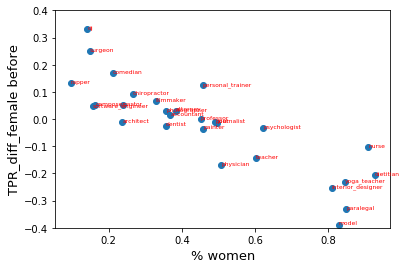

Correlation: -0.4908375970208534; p-value: 0.009332866231066866


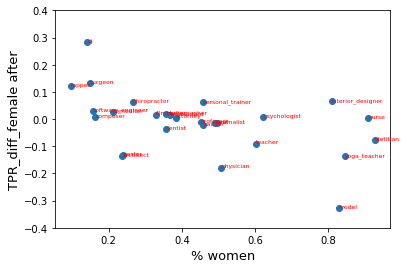

Correlation: -0.6041345489065336; p-value: 0.0006629858782939629


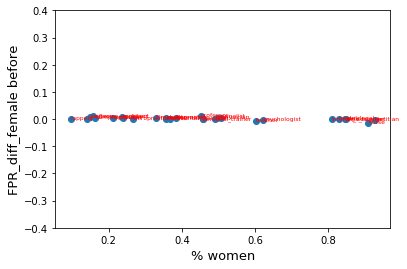

Correlation: -0.36497991667034846; p-value: 0.06121809006755033


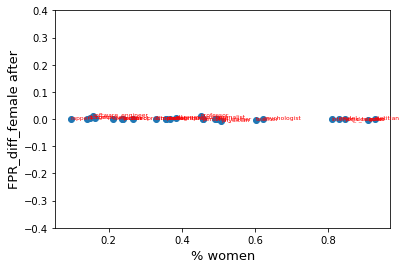

rms-diff before: 0.16237962492055028; rms-diff after: 0.11187268781391523


In [119]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict(x_test.dot(P))
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

### print(fprs_change_after)

In [114]:
y_test

array([ 2, 21,  2, ..., 26, 25, 22])

In [70]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = list(set(labels)) # ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'b', 'r', 'orange'
  markers = ["s", "o"]

  for i, c, label, marker in zip(set(labels.tolist()), colors, names, markers):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3, marker = marker)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig(title, dpi = 600)          
  plt.show()
  return vecs_2d

53
447


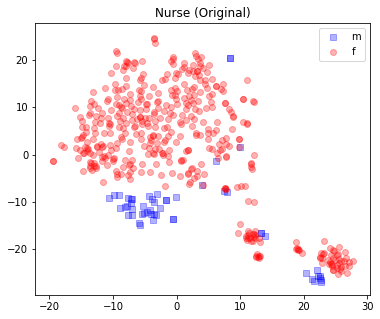

53
447


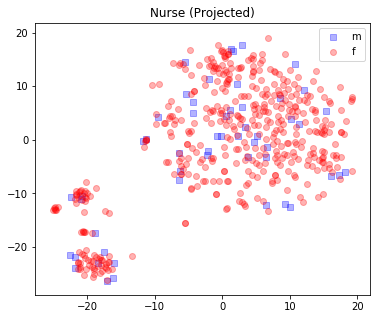

261
239


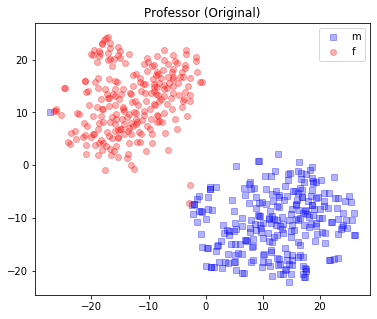

261
239


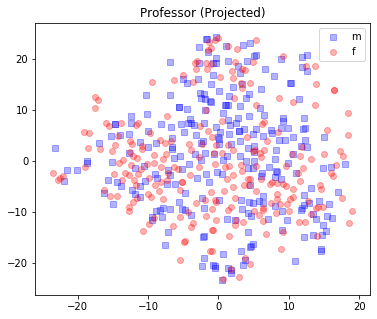

291
209


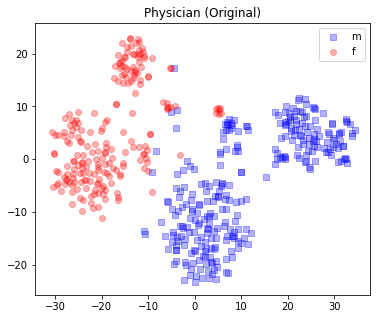

291
209


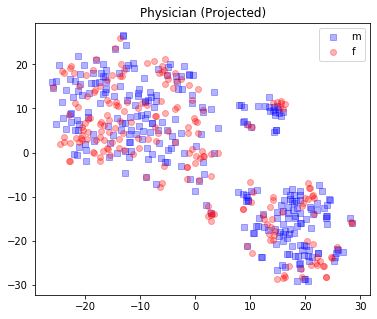

315
185


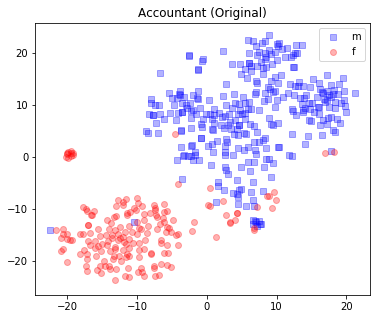

315
185


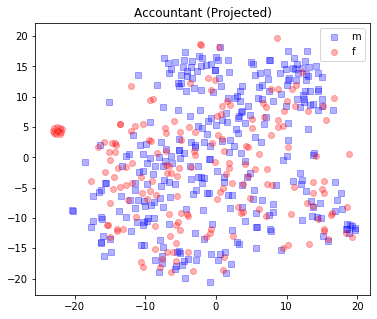

125
24


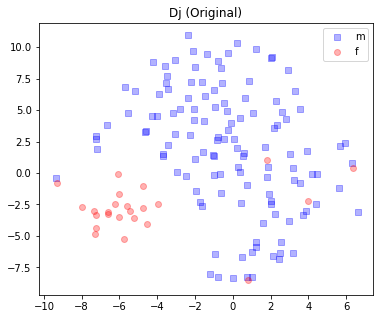

125
24


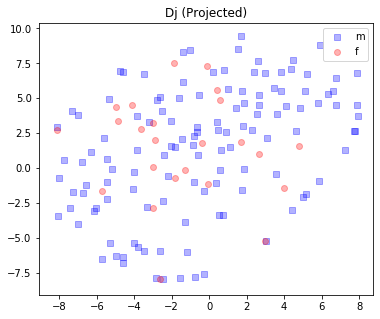

27
372


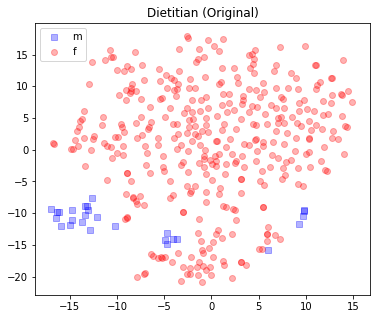

27
372


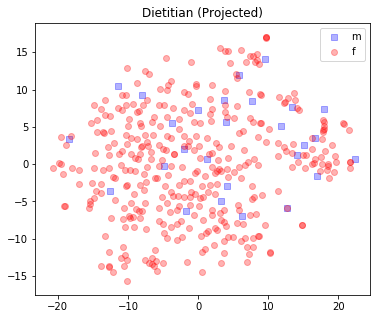

In [72]:
y_dev_gender = np.array([d["g"] for d in dev])
n = 500
for prof in ["nurse", "professor", "physician", "accountant", "dj", "dietitian"]:
    
    idx = np.random.rand(x_dev.shape[0]) < 0.1
    prof_idx = y_dev == p2i[prof]  
    prof_upper = prof[0].upper() + prof[1:]
    tsne_by_gender(x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Original)".format(prof_upper))
    tsne_by_gender((x_dev[prof_idx].dot(P))[:n], y_dev_gender[prof_idx][:n], "{} (Projected)".format(prof_upper))

In [ ]:
tsne_by_gender(x_dev[:n], y_dev_gender[:n], "All (Original)".format(prof_upper))
tsne_by_gender((x_dev.dot(P))[:n], y_dev_gender[:n], "All (Projected)".format(prof_upper))

In [39]:
print(prof2fem)

{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}
